In [139]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/time-series-starter-dataset/Month_Value_1.csv


In [140]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("podsyp/time-series-starter-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/time-series-starter-dataset


In [141]:
df=pd.read_csv("/kaggle/input/time-series-starter-dataset/Month_Value_1.csv")
df['Period']=pd.to_datetime(df['Period'],dayfirst=False,yearfirst=False,format="%d.%m.%Y")
df.sort_values(by='Period',inplace=True)
sales_pred_df=df.copy()
sales_pred_df=sales_pred_df[['Period','Sales_quantity']]
sales_pred_df['Period']=sales_pred_df['Period'].dt.to_period('M')
if sales_pred_df.shape[1]>1:
    sales_pred_df=sales_pred_df.set_index('Period')

    

In [142]:
sales_pred_df.head()

,Sales_quantity
Period,
2015-01,12729.0
2015-02,11636.0
2015-03,15922.0
2015-04,15227.0
2015-05,8620.0


/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


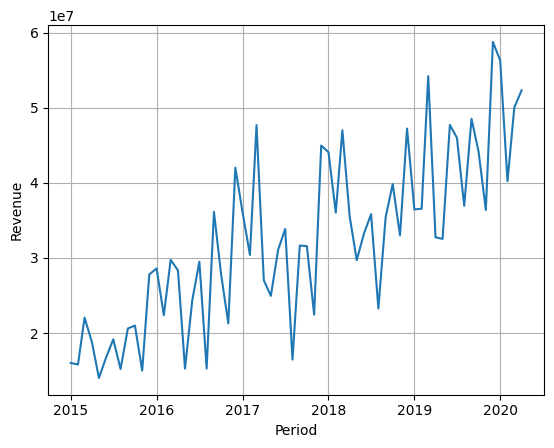

In [143]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.lineplot(x=df['Period'],y=df['Revenue'])
plt.grid()

In [167]:
#first and last rows with NaN
df.loc[df['Revenue'].isna()].iloc[[0,-1],:]

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Period,Revenue,Sales_quantity,Average_cost,The_average_annual_payroll_of_the_region
60,2020-01-01,5.628830e+07,27184.0,2070.640850,29044998.0
61,2020-02-01,4.022524e+07,23509.0,1711.057181,29044998.0
62,2020-03-01,5.002217e+07,32569.0,1535.882748,29044998.0
63,2020-04-01,5.232069e+07,26615.0,1965.834790,29044998.0
64,2020-05-01,NaN,NaN,NaN,NaN
65,2020-06-01,NaN,NaN,NaN,NaN
66,2020-07-01,NaN,NaN,NaN,NaN
67,2020-08-01,NaN,NaN,NaN,NaN
68,2020-09-01,NaN,NaN,NaN,NaN
69,2020-10-01,NaN,NaN,NaN,NaN


In [145]:
import statsmodels.api as sm
comp=sales_pred_df.copy()
comp=comp.loc[~comp['Sales_quantity'].isna()]
comp.index = comp.index.to_timestamp()
comp = comp.asfreq('MS')  
decompose = sm.tsa.seasonal_decompose(comp['Sales_quantity'],model='multiplicative')


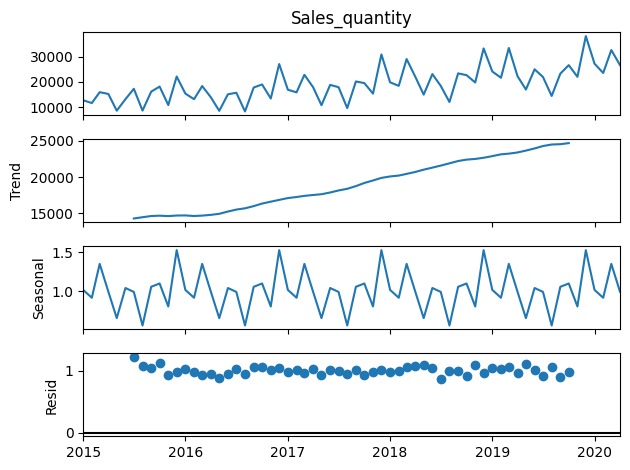

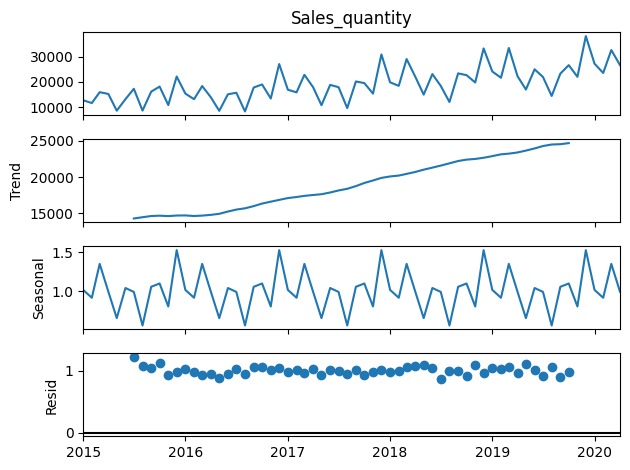

In [146]:
decompose.plot()

In [186]:
def plot_data_points(train,pred=None,test=None,title=None):
    plt.figure(figsize=(17,5))
    plt.plot(train,label="Train")
    if test: plt.plot(test,label="Test")
    if pred: plt.plot(pred,label="Predict")
    plt.legend()
    plt.grid()
    plt.title(title)
    plt.show()
    

In [148]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
def holt_holtswinter_exp_smth(num_points,train,seasonal_periods=12,trend='multiplicative',
                  seasonal=None,smoothing_level=0.2,smoothing_trend=0.04,boxcox=False):
    model= ExponentialSmoothing(train,seasonal_periods=seasonal_periods,
                               trend=trend,seasonal=seasonal,use_boxcox=boxcox)
    model_fit = model.fit(smoothing_level=smoothing_level,smoothing_trend=smoothing_trend)
    
    return model_fit.forecast(num_points)

In [149]:
def split(num_points,data):
    train=data[:len(data)-num_points]
    test=data[len(data)-num_points:]
    return train,test

In [150]:
num_points=12
seasonal_periods=12
trend='multiplicative'
seasonal=None
smoothing_level=0.02
smoothing_trend=0.4
boxcox=True
title="Holts"
def make_forecast(title,data,num_points=num_points,seasonal_periods=seasonal_periods,trend=trend,seasonal=seasonal,smoothing_level=smoothing_level,smoothing_trend=smoothing_trend,boxcox=boxcox):
    train,test=split(num_points,comp)
    pred=holt_holtswinter_exp_smth(num_points,train,seasonal_periods=seasonal_periods,trend=trend,seasonal=seasonal,smoothing_level=smoothing_level,smoothing_trend=smoothing_trend,boxcox=boxcox)
    plot_data_points(train,pred,test,title)
    return train,test,pred

In [151]:
import numpy as np
def get_score_metrics(true,y_pred):

    y_true=true.copy()
    y_true=y_true.iloc[:,0]
    metrics={'metric':[],'score':[]}
    
    mfe = np.mean(y_true - y_pred).round(3)
    metrics['metric'].append('MFE')
    metrics['score'].append(mfe)
    
    mae = np.mean(np.abs(y_true - y_pred)).round(3)
    metrics['metric'].append('MAE')
    metrics['score'].append(mae)
    
    mape = (np.mean(np.abs((y_true - y_pred) / y_true)) * 100).round(3)
    metrics['metric'].append('MAPE')
    metrics['score'].append(mape)

    mse = np.mean((y_true - y_pred)**2).round(3)
    metrics['metric'].append('MSE')
    metrics['score'].append(mse)

    rmse = np.sqrt(mse).round(3)
    metrics['metric'].append('RMSE')
    metrics['score'].append(rmse)

    metric_df=pd.DataFrame(metrics)
    return metric_df
    

In [152]:
num_points=12
seasonal_periods=12
trend='multiplicative'
seasonal=None
smoothing_level=0.02
smoothing_trend=0.4
boxcox=True
title="Holts"

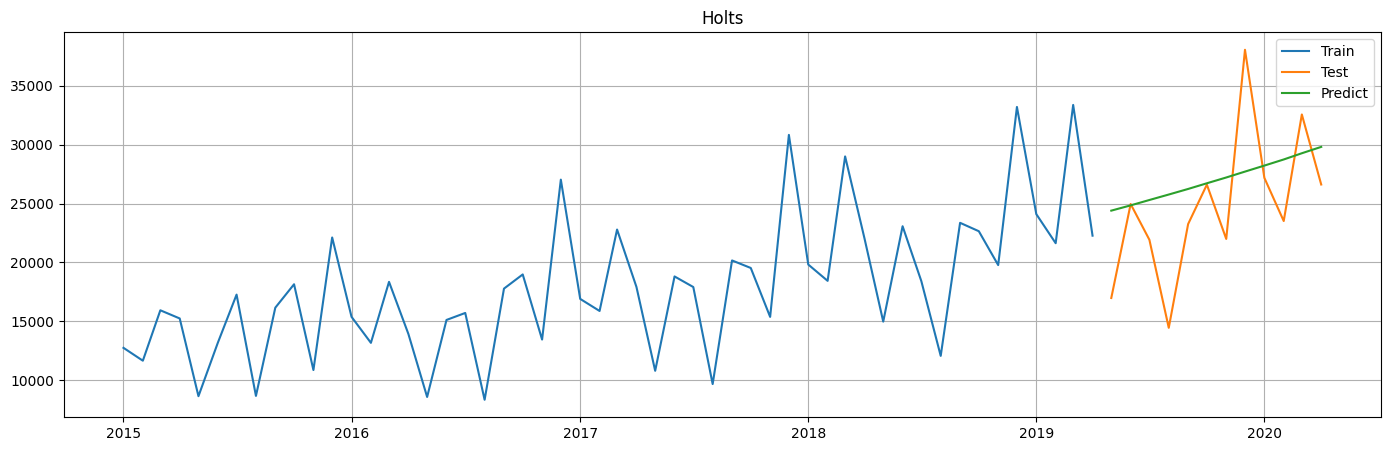

In [153]:
train,test,pred=make_forecast(title,comp,num_points=num_points,seasonal_periods=seasonal_periods,trend=trend,seasonal=seasonal,smoothing_level=smoothing_level,smoothing_trend=smoothing_trend,boxcox=boxcox)

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/holtwinters/model.py:84: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


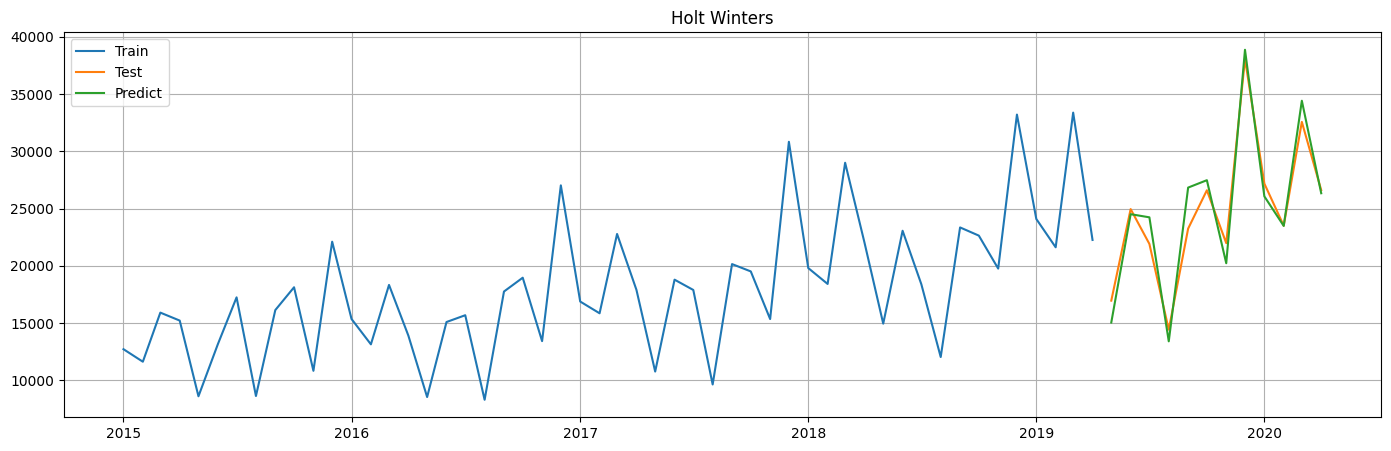

In [154]:
num_points=12
seasonal_periods=12
trend='multiplicative'
seasonal='multiplicative'
smoothing_level=0.4
smoothing_trend=0.4
boxcox=True
title="Holt Winters"
train,test,pred=make_forecast(title,comp,num_points=num_points,seasonal_periods=seasonal_periods,trend=trend,seasonal=seasonal,smoothing_level=smoothing_level,smoothing_trend=smoothing_trend,boxcox=boxcox)

In [155]:
display(get_score_metrics(test,pred))

,metric,score
0,MFE,-241.772
1,MAE,1329.661
2,MAPE,5.860
3,MSE,2693034.912
4,RMSE,1641.047


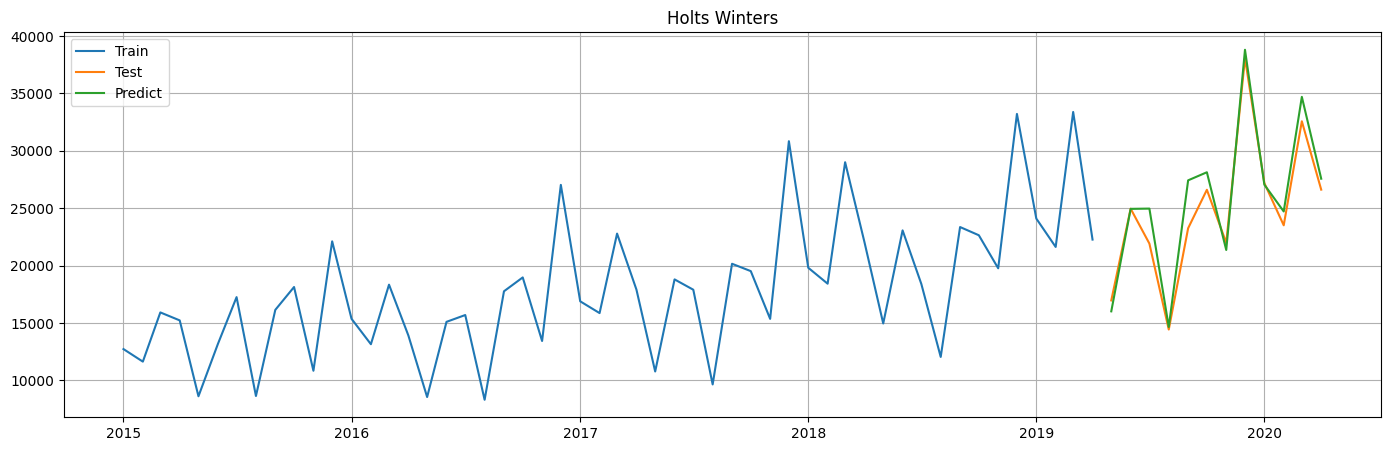

In [156]:
num_points=12
seasonal_periods=12
trend='multiplicative'
seasonal='additive'
smoothing_level=0.4
smoothing_trend=0.4
boxcox=True
title="Holts Winters"
train1,test1,pred1=make_forecast(title,comp,num_points=num_points,seasonal_periods=seasonal_periods,trend=trend,seasonal=seasonal,smoothing_level=smoothing_level,smoothing_trend=smoothing_trend,boxcox=boxcox)

In [157]:
display(get_score_metrics(test1,pred1))

,metric,score
0,MFE,-1020.621
1,MAE,1308.853
2,MAPE,5.439
3,MSE,3149145.694
4,RMSE,1774.583


In [158]:
import joblib
from joblib import dump,load

In [159]:
num_points=sales_pred_df.loc[sales_pred_df['Sales_quantity'].isna()].shape[0]
seasonal_periods=12
trend='multiplicative'
seasonal='additive'
smoothing_level=0.4
smoothing_trend=0.4
boxcox=True
sales_df=sales_pred_df.copy()
sales_df=sales_df.loc[~sales_df['Sales_quantity'].isna()]
my_model=ExponentialSmoothing(sales_df,seasonal_periods=seasonal_periods,
                               trend=trend,seasonal=seasonal,use_boxcox=boxcox)
model_fit = my_model.fit(smoothing_level=smoothing_level,smoothing_trend=smoothing_trend)
joblib.dump(my_model,"model-time-series-starter-dataset.pkl")

['model-time-series-starter-dataset.pkl']

In [180]:
res=pd.concat([sales_df,forecast],axis=0)

In [181]:
res['Sales_quantity']=res['Sales_quantity'].round(2)

pandas.core.indexes.datetimes.DatetimeIndex

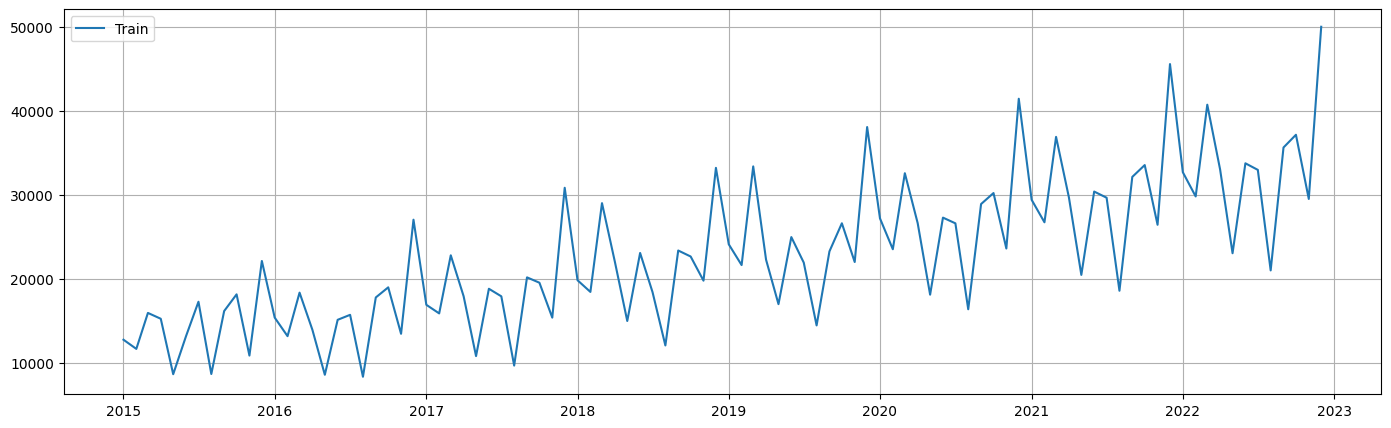

In [191]:
res.index = res.index.to_timestamp()
plot_data_points(res)